In [ ]:
!pip install sentence_transformers
!pip install faiss-gpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 8.1 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
import ast
import faiss
import torch
import os

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
def get_embedding(model_name, text):
    model = SentenceTransformer(model_name)
    embeddings = model.encode(text)
    return embeddings

In [ ]:
def get_fact_text(fact):
    fact_list = []
    for row in fact.itertuples(index=True, name='Pandas'):
        val = getattr(row, 'claim')
        tuple_data = ast.literal_eval(val)
        fact_list.append(tuple_data[1])
    return fact_list

In [ ]:
def get_post_text(post, col_name):
    post_text = []

    if col_name == 'ocr':
        for row in post.itertuples(index=True, name='Pandas'):
            val = getattr(row, col_name)
            q = ast.literal_eval(val)
            if not val or not q:
                post_text.append('')
            else:
                tup = q[0]
                post_text.append(tup[1])

    elif col_name == 'text':
        for row in post.itertuples(index=True, name='Pandas'):
            val = getattr(row, col_name)
            if not val:
                post_text.append('')
            else:
                #print(val)
                q = ast.literal_eval(val)
                post_text.append(q[1])
    return post_text

In [ ]:
def sep_empty(post, col_name):
    empty_num = 0
    sep_row = []
    for row in post.itertuples(index=True, name='Pandas'):
        val = getattr(row, col_name)
        if not val or val == '[]':
            empty_num += 1
        else:
            sep_row.append(row._asdict())

    sep_df = pd.DataFrame(sep_row)
    return sep_df

In [ ]:
def clean_Nan(post, col_name):
    post_cleaned = post.copy()
    post_cleaned[col_name] = post_cleaned[col_name].fillna("")

    return post_cleaned

In [ ]:
def get_embeddings_in_batches(model, texts, batch_size=512):
    """Generate embeddings for a list of texts using batch processing."""
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        with torch.cuda.amp.autocast(enabled=True):  # Mixed precision
            batch_embeddings = model.encode(batch_texts, convert_to_tensor=False, device=device)
        embeddings.append(batch_embeddings)
    return np.vstack(embeddings)

In [ ]:
def build_faiss_index(embeddings):
    """Build a FAISS index for fast similarity search."""
    dimension = embeddings.shape[1]
    index = faiss.IndexFlatIP(dimension)  # Inner product (for cosine similarity)
    faiss.normalize_L2(embeddings)       # Normalize embeddings for cosine similarity
    index.add(embeddings)
    return index

In [ ]:
def search_faiss(index, query_embeddings, top_k=10):
    """Search FAISS index with query embeddings."""
    faiss.normalize_L2(query_embeddings)
    distances, indices = index.search(query_embeddings, top_k)
    return distances, indices

In [ ]:
def visualize_metrics(mrr, success_at_k, k_values):
    """
    Visualize MRR and Success@k as bar plots and line charts.

    Parameters:
        mrr (float): Mean Reciprocal Rank.
        success_at_k (dict): Dictionary with k values as keys and Success@k as values.
        k_values (list): List of k values used for evaluation.
    """
    import matplotlib.pyplot as plt

    # Bar plot for Success@k
    success_values = [success_at_k[k] for k in k_values]
    plt.figure(figsize=(10, 6))
    plt.bar([str(k) for k in k_values], success_values, color='skyblue')
    plt.title('Success@k for Different k Values')
    plt.xlabel('k')
    plt.ylabel('Success@k')
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    # Line plot for MRR
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, success_values, marker='o', color='orange', label='Success@k')
    plt.axhline(y=mrr, color='green', linestyle='--', label=f'MRR: {mrr:.4f}')
    plt.title('MRR and Success@k Trends')
    plt.xlabel('k')
    plt.ylabel('Metric Value')
    plt.legend()
    plt.grid(alpha=0.7)
    plt.show()


Modified Pipeline with Success

In [ ]:
def pipeline(posts_file, fact_checks_file, pairs_file, batch_size=512, model_name='sentence-transformers/all-MiniLM-L6-v2', use_ocr=True, use_txt=True, k_values=None):
    #model_name = 'sentence-transformers/distiluse-base-multilingual-cased-v1'

    if k_values is None:
        k_values = [1, 5, 10, 20, 50, 100, 1000]  # Default values for k

    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    post = pd.read_csv(posts_file)
    fact = pd.read_csv(fact_checks_file)
    pairs = pd.read_csv(pairs_file)

    fact_list = get_fact_text(fact)
    combined = False
    if use_ocr and use_txt:
        clean_ocr = clean_Nan(post,'ocr')
        clean_text = clean_Nan(post,'text')

        ocr_list = get_post_text(clean_ocr,'ocr')
        text_list = get_post_text(clean_text,'text')

        post_list = [f"{a}{' ' if a and b else ''}{b}" for a, b in zip(ocr_list, text_list)]
        combined = True

    elif use_ocr:
        clean_ocr = clean_Nan(post,'ocr')
        sep_ocr = sep_empty(clean_ocr,'ocr')
        post_list = get_post_text(sep_ocr,'ocr')

    elif use_txt:
        clean_text = clean_Nan(post,'text')
        sep_text = sep_empty(clean_text,'text')
        post_list = get_post_text(sep_text,'text')
    #model_name = 'sentence-transformers/distiluse-base-multilingual-cased-v1'
    # Load model
    model = SentenceTransformer(model_name, device=device)

    print("Generating fact embeddings...")
    fact_embeddings = get_embeddings_in_batches(model, fact_list, batch_size=batch_size)
    #fact_embeddings = get_embedding(model_name, fact_list)


    print("Generating post embeddings...")
    post_embeddings = get_embeddings_in_batches(model, post_list, batch_size=batch_size)
    #post_embeddings = get_embedding(model_name, post_list)

    # Build FAISS index for fact embeddings
    print("Building FAISS index...")
    index = build_faiss_index(fact_embeddings)

    # Search for top-k similar fact-checks for each post
    print("Performing FAISS search...")
    top_k = max(k_values) if k_values else 1000
    distances, indices = search_faiss(index, post_embeddings, top_k)

    # Map results back to DataFrame for evaluation
    results = []
    for i, (dists, idxs) in enumerate(zip(distances, indices)):
        post_id = post.iloc[i]['post_id']
        for dist, idx in zip(dists, idxs):
            fact_check_id = fact.iloc[idx]['fact_check_id']
            results.append({'post_id': post_id, 'fact_check_id': fact_check_id, 'similarity': dist})

    results_df = pd.DataFrame(results)
    print(len(results_df))
    print(len(post))


    # Evaluate performance using MRR
    print("Evaluating MRR...")
    mrr = 0
    mrr_num = 0
    index_error_num = 0
    for i, row in pairs.iterrows():
        correct_fact_id = row['fact_check_id']
        post_id = row['post_id']
        top_results = results_df[results_df['post_id'] == post_id]
        try:
            rank = top_results[top_results['fact_check_id'] == correct_fact_id].index[0] + 1
            mrr += 1 / rank
            mrr_num += 1
        except IndexError:
            index_error_num += 1
            continue
    mrr /= len(pairs)
    print(f"Mean Reciprocal Rank (MRR): {mrr:.4f}")
    print('mrr num')
    print(mrr_num)
    print('index error num')
    print(index_error_num)

    # Evaluate Success@k
    if k_values is None:
        k_values = [1, 5, 10, 20, 50, 100, 1000]  # Default k values

    print("Evaluating Success@k...")
    success_at_k = {}

    for k in k_values:
        success = 0
        total_queries = 0

        for _, row in pairs.iterrows():
            correct_fact_id = row['fact_check_id']
            post_id = row['post_id']
            top_results = results_df[results_df['post_id'] == post_id].head(k)

            if correct_fact_id in top_results['fact_check_id'].values:
                success += 1

            total_queries += 1

        success_at_k[k] = success / total_queries if total_queries else 0

    # Print Success@k results
    print("Success@k Results:")
    for k in k_values:
        print(f"Success@{k}: {success_at_k[k]:.4f}")


    visualize_metrics(mrr, success_at_k, k_values)


    # Save results
    results_df.to_csv("faiss_results_full.csv", index=False)
    print("Results saved to faiss_results_full.csv")




Generating fact embeddings...


<ipython-input-31-acb4b98c96a3>:6: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):  # Mixed precision


Generating post embeddings...
Building FAISS index...
Performing FAISS search...
24431000
24431
Evaluating MRR...
Mean Reciprocal Rank (MRR): 0.0000
mrr num
23080
index error num
2663
Evaluating Success@k...
Success@k Results:
Success@1: 0.2511
Success@5: 0.5172
Success@10: 0.6125
Success@100: 0.7916
Success@1000: 0.8966


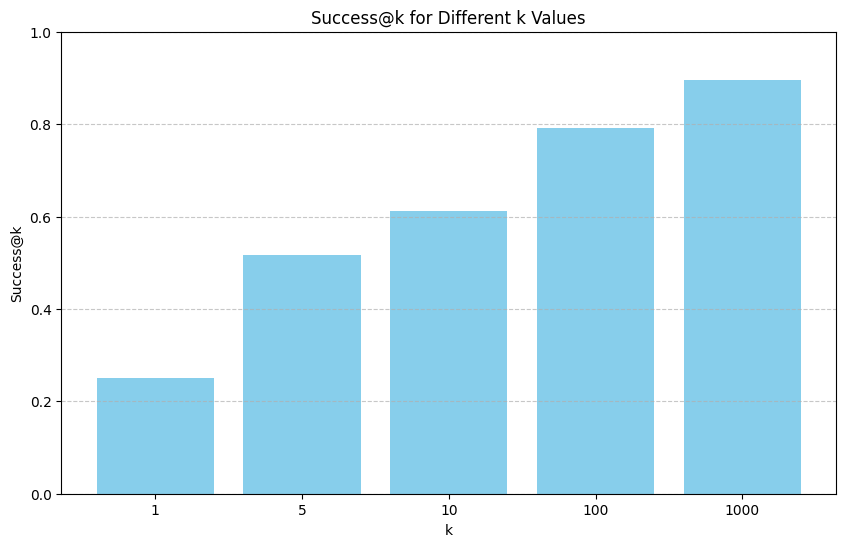

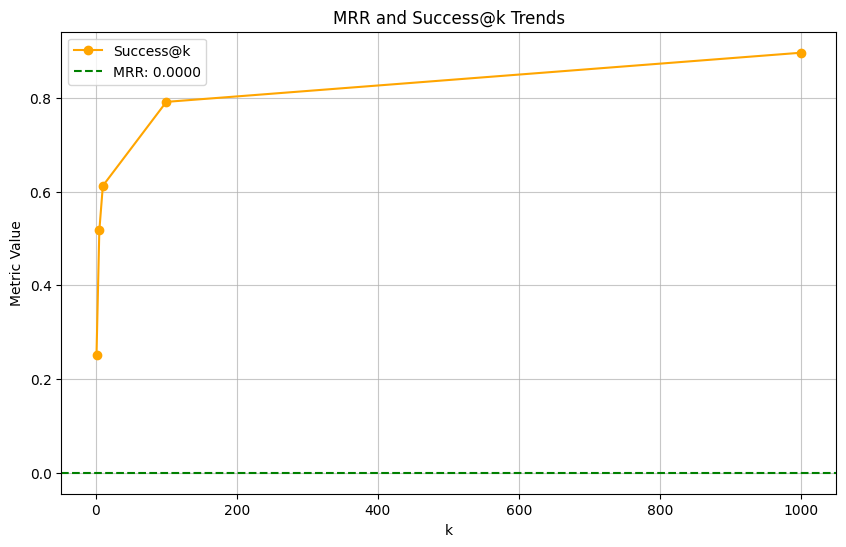

Results saved to faiss_results_full.csv


In [ ]:
posts_file = 'drive/MyDrive/Sem_Sim_proj/posts.csv'
fact_checks_file = 'drive/MyDrive/Sem_Sim_proj/fact_checks.csv'
pairs_file = 'drive/MyDrive/Sem_Sim_proj/pairs.csv'
k_values = [1, 5, 10, 100, 1000]
pipeline(posts_file, fact_checks_file, pairs_file, use_txt=True, use_ocr=True, k_values=k_values)